In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

%matplotlib inline

In [2]:
class Loader:

    def __init__(self, files):
        self.files = files

    def get_data(self):
        dfs = []
        for file in self.files:
            df = self.load_past_matches(file)
            dfs.append(df)
        
        df_join = self.join_data(dfs[0], dfs[1])
        self.drop_irrelevant_columns(df_join)

        return df_join

    def load_past_matches(self, file):
        df = pd.read_csv(f'../../data/{file}')
        df.drop('Unnamed: 0', axis=1, inplace=True)
        df['date'] = pd.to_datetime(df['date']).dt.date

        return df

    def join_data(self, df1, df2):
        df = pd.merge(df1, df2,  how='inner',
            left_on=['league', 'date','team', 'opponent', 'home'],
            right_on=['league', 'date','team', 'opponent', 'home'])
        df.sort_values(by=['date', 'league', 'team', 'opponent'], inplace=True)
        df.reset_index(inplace=True, drop=True)
              
        return df
    
    def drop_irrelevant_columns(self, df):
        df.drop(['team_goals_scored',
               'opponent_goals_scored',
               'team_goals_conceded',
               'opponent_goals_conceded'], axis=1, inplace=True)

In [3]:
FILES = ["elos_matches.csv", "goals_matches.csv"]
loader = Loader(FILES)
data = loader.get_data()
data.shape

(75428, 35)

In [4]:
def build_dataset(df):
    df_copy = df.copy()
    df_copy.reset_index(inplace=True, drop=True)
    date = df_copy[['date']].iloc[:,0]
    df_copy.drop(['league', 'date', 'team', 'opponent'], axis=1, inplace=True)
    df_copy['date'] = date
    df_copy.sort_values(by=['date'], inplace=True)
    df_copy.drop(['date'], axis=1, inplace=True)
    
    X = df_copy.drop(['result'], axis=1).to_numpy()
    Y = np.array(df_copy['result']) / 0.5
    
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).long()
    
    return X, Y

def add_past_to_row(df, i):
    df_past = df.copy()
    df_past.index += i
    df_past.rename(columns={c: c+f'_{i}' for c in df_past.columns if c not in ['league',
                                                                               'date',
                                                                               'team',
                                                                               'opponent']}, inplace=True)
    return df_past

def build_matches_dataset(df, past_matches, team):
    dfs_past = []
    df_team = df[df['team']==team]
    for i in range(1, past_matches+1):
        df_past = add_past_to_row(df_team, i)
        dfs_past.append(df_past)

    df_team_joined = df_team.copy()
    for df_past in dfs_past:
        df_team_joined = pd.concat([df_team_joined, df_past],
                                    axis=1,
                                    )
    df_team_joined = df_team_joined[past_matches:-past_matches]

    return df_team_joined

def build_teams_dataset(df, past_matches):
    dfs = []
    for team in df['team'].unique():
        df_team_joined = build_matches_dataset(df, past_matches, team)
        dfs.append(df_team_joined)
    dfs = pd.concat(dfs)
    dfs.insert(5, 'result_0', 0)
    dfs = add_opponent_past_matches(dfs)
    dfs = ordering_columns(dfs, past_matches)

    return dfs

def add_opponent_past_matches(df):
    df = df.loc[:,~df.columns.duplicated()].copy()
    df_copy = df.copy()
    keep_same = {'league', 'date', 'team', 'opponent', 'result'}
    df_copy.columns = ['{}{}'.format(c, '' if c in keep_same else '_y') for c in df_copy.columns]
    df_copy['result'] = 1 - df_copy['result']
    df_copy.rename(columns={'team': 'opponent', 'opponent': 'team'}, inplace=True)
    df_combined = pd.merge(df, df_copy, how='left',
                          left_on=['league', 'date', 'team', 'opponent', 'result'],
                          right_on=['league', 'date', 'team', 'opponent', 'result'])
    return df_combined

def ordering_columns(df, past_matches):
    index_columns = ['league', 'date', 'team', 'opponent', 'result']
    template_columns = ['result', 'elo_team', 'elo_opponent', 'elo_diff', 'home', 'team_goals_scored_avg',
                       'team_goals_conceded_avg', 'team_goals_scored_avg_home',
                       'team_goals_conceded_avg_home', 'team_goals_scored_avg_away',
                       'team_goals_conceded_avg_away', 'opponent_goals_scored_avg',
                       'opponent_goals_conceded_avg', 'opponent_goals_scored_avg_home',
                       'opponent_goals_conceded_avg_home', 'opponent_goals_scored_avg_away',
                       'opponent_goals_conceded_avg_away', 'league_home_goals_scored',
                       'league_away_goals_scored', 'league_home_goals_scored_avg',
                       'league_away_goals_scored_avg', 'league_home_goals_conceded',
                       'league_away_goals_conceded', 'league_home_goals_conceded_avg',
                       'league_away_goals_conceded_avg', 'team_attack_strength',
                       'team_defense_strength', 'opponent_attack_strength',
                       'opponent_defense_strength', 'team_lambda', 'opponent_lambda']
    template_columns_y = [s + f'_y' for s in template_columns]
    columns = [[index_columns + ['result_0'] + template_columns[1:] + ['result_0_y'] + template_columns_y[1:]]]
    for i in range(1, past_matches+1):
        team_cols = [s + f'_{i}' for s in template_columns]
        opp_cols = [s + f'_{i}_y' for s in template_columns]
        columns.append([team_cols, opp_cols])

    columns = [subitem for sublist in columns for item in sublist for subitem in item]
    df = df[columns]
    df.dropna(inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df

def build_wavenet_dataset(df, past_matches=7):
    df_copy = df.copy()
    df_copy.sort_values(by=['team', 'date'], inplace=True)
    df_copy.reset_index(inplace=True, drop=True)
    dfs = build_teams_dataset(df_copy, past_matches)
    X, Y = build_dataset(dfs)
    
    return X, Y, dfs

In [5]:
Xall, Yall, dfs = build_wavenet_dataset(data, 7)

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/2219273965.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [6]:
PATH = "../../src/model/trained_models/wavenet_9.pt"
# model.load_state_dict(torch.load(PATH))
model = torch.load(PATH)
model.train()

Sequential(
  (0): Conv1d(1, 32, kernel_size=(62,), stride=(62,))
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): Conv1d(32, 64, kernel_size=(2,), stride=(2,))
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Tanh()
  (6): Conv1d(64, 128, kernel_size=(2,), stride=(2,))
  (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Tanh()
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=256, out_features=3, bias=True)
)

In [7]:
@torch.no_grad()
def split_loss(x, y):
    x = x[:, None, :]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [8]:
@torch.no_grad()
def accuracy(x, y):    
    x = x[:, None, :]
    logits = model(x)
    preds = []
    preds = torch.argmax(logits, dim=1)

    i = 0
    for pred, true in zip(preds, y):
        if pred == true:
            i += 1
    
#     print(f"----{split}----")
    print(f"Correctly predicted {i} out of {y.shape[0]}.")
    print(f"{i / y.shape[0]:.4f}")
    print(f"Guessing would give an accuracy of {1 / len(torch.unique(y))}")

In [9]:
# accuracy(Xall, Yall)

In [21]:
@torch.no_grad()
def get_predictions(x, df):
    x = x[:, None, :]
    logits = model(x)
    preds = []
    preds = torch.softmax(logits, dim=1)
    print(preds)
#     print(preds.numpy())
#     print(pd.DataFrame(preds.numpy()))
    df[['loss', 'draw', 'win']] = pd.DataFrame(preds.cpu().numpy())
    
    return df

In [22]:
start_date = pd.to_datetime('2020-09-01')
data_20 = data[data['date']>=start_date]

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/3845881422.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  data_20 = data[data['date']>=start_date]


In [23]:
X_20, Y_20, dfs_20 = build_wavenet_dataset(data_20, 7)

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/2219273965.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [24]:
X_20.to("mps").device

device(type='mps', index=0)

In [25]:
dfs_preds = dfs_20.copy()
dfs_preds = dfs_preds[['date', 'team', 'opponent',
                       'result', 'elo_team', 'elo_opponent', 'elo_diff', 'home',
                       'team_goals_scored_avg', 'team_goals_conceded_avg', 'team_goals_scored_avg_home',
                       ]]
dfs_preds.sort_values('date', inplace=True)
dfs_preds.reset_index(inplace=True, drop=True)
dfs_preds = get_predictions(X_20.to("mps"), dfs_preds)

tensor([[0.2237, 0.3023, 0.4740],
        [0.3996, 0.3214, 0.2789],
        [0.1478, 0.3277, 0.5245],
        ...,
        [0.3008, 0.6066, 0.0927],
        [0.2012, 0.6102, 0.1885],
        [0.1980, 0.6177, 0.1843]], device='mps:0')


In [26]:
dfs_preds_cut = dfs_preds.copy()
dfs_preds_cut['prediction'] = dfs_preds_cut[['loss', 'draw', 'win']].idxmax(axis=1)
dfs_preds_cut['prediction'] = dfs_preds_cut['prediction'].replace({'win': 1, 'draw': 0.5, 'loss': 0})
dfs_preds_cut['correct'] = np.where((dfs_preds_cut['result'] == dfs_preds_cut['prediction']), 1, 0)

In [27]:
dfs_preds_cut['correct'].mean()

0.5244307794582017

In [28]:
dfs_preds.head()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win
0,2020-10-21,arezzo,padova,0.0,1403.476732,1490.770826,-87.294094,1.0,1.052632,1.315789,1.473684,0.223667,0.302342,0.473990
1,2020-10-21,feralpisalò,modena,0.5,1476.762103,1440.813767,35.948336,0.0,1.368421,1.315789,1.526316,0.399612,0.321445,0.278944
2,2020-10-21,albinoleffe,renate,1.0,1399.837508,1492.391716,-92.554208,1.0,1.000000,1.000000,1.000000,0.147784,0.327685,0.524531
3,2020-10-21,padova,arezzo,1.0,1490.770826,1403.476732,87.294094,0.0,1.263158,0.842105,1.263158,0.333284,0.207539,0.459178
4,2020-10-21,renate,albinoleffe,0.0,1492.391716,1399.837508,92.554208,0.0,1.210526,1.105263,1.368421,0.413313,0.292062,0.294625


## Odds Data

In [29]:
odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)
odds_fd = odds_fd.loc[:,~odds_fd.columns.str.contains('Unnamed')]
odds_fd.dropna(subset='home_team', inplace=True)
odds_fd['date'] = pd.to_datetime(odds_fd['date']).dt.date
odds_fd['home_team'] = odds_fd['home_team'].replace(' ', '_', regex=True).str.lower()
odds_fd['away_team'] = odds_fd['away_team'].replace(' ', '_', regex=True).str.lower()
odds_fd = odds_fd[['div', 'date', 'home_team', 'away_team', 'FTR', 'B365H', 'B365D', 'B365A']]
odds_fd.head()

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/931263150.py:1: DtypeWarning: Columns (3,11,118,145) have mixed types. Specify dtype option on import or set low_memory=False.
  odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)
/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/931263150.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)


,div,date,home_team,away_team,FTR,B365H,B365D,B365A
0,I1,2022-08-13,milan,udinese,H,1.44,4.75,7.00
1,I1,2022-08-13,sampdoria,atalanta,A,4.33,3.90,1.75
2,I1,2022-08-13,lecce,inter,A,10.00,5.75,1.28
3,I1,2022-08-13,monza,torino,A,2.60,3.30,2.75
4,I1,2022-08-14,fiorentina,cremonese,H,1.36,5.00,8.50


In [30]:
conditions  = [odds_fd['FTR']=='H', odds_fd['FTR']=='D', odds_fd['FTR']=='A']
choices     = [1, 0.5, 0]
odds_fd['FTR'] = np.select(conditions, choices)
odds_fd.rename(columns={'FTR': 'result',
                        'B365H': 'team_odds',
                        'B365A': 'opponent_odds',
                        'B365D': 'draw_odds'}, inplace=True)

In [31]:
def duplicate_to_team_and_opponent(df_matches):
    df_matches_copy = df_matches.copy()
    df_matches = df_matches.rename(columns={'home_team': 'team', 'away_team': 'opponent'})
    df_matches_copy = df_matches_copy.rename(columns={'away_team': 'team', 'home_team': 'opponent', 'team_odds': 'opponent_odds',
                                            'opponent_odds': 'team_odds'})
    df_matches_copy = df_matches_copy[['div', 'date', 'team', 'opponent', 'result', 'team_odds', 'opponent_odds', 'draw_odds'
                        ]]
    df_matches.loc[:, 'home'] = 1
    df_matches_copy.loc[:, 'home'] = 0
    df_matches = df_matches.append(df_matches_copy)
    df_matches.sort_values(by='date', inplace=True)

    return df_matches

In [32]:
odds_fd_t_o = duplicate_to_team_and_opponent(odds_fd)
odds_fd_t_o = odds_fd_t_o[odds_fd_t_o['div']=='I1']

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/3018900667.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_matches = df_matches.append(df_matches_copy)


In [33]:
joined_fd = pd.merge(dfs_preds_cut, odds_fd_t_o,
                     left_on=['team', 'opponent', 'date', 'result', 'home'],
                     right_on=['team', 'opponent', 'date', 'result', 'home'],
                     how='inner')
joined_fd.head()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win,prediction,correct,div,team_odds,draw_odds,opponent_odds
0,2020-11-21,crotone,lazio,0.0,1473.468583,1585.784346,-112.315763,1.0,1.684211,1.684211,1.684211,0.400639,0.344147,0.255214,0.0,1,I1,4.75,4.00,1.66
1,2020-11-21,juventus,cagliari,1.0,1579.859034,1517.222736,62.636298,1.0,1.947368,1.789474,2.157895,0.198107,0.452943,0.348950,0.5,0,I1,1.28,5.50,10.00
2,2020-11-21,spezia,atalanta,0.5,1526.152035,1625.779814,-99.627779,1.0,1.157895,1.421053,1.684211,0.413909,0.299021,0.287069,0.0,0,I1,6.50,5.25,1.40
3,2020-11-21,atalanta,spezia,0.5,1625.779814,1526.152035,99.627779,0.0,1.894737,1.421053,2.526316,0.155540,0.335597,0.508863,1.0,0,I1,1.40,5.25,6.50
4,2020-11-22,fiorentina,benevento,0.0,1544.145261,1480.149439,63.995823,1.0,1.578947,1.368421,1.315789,0.126462,0.270746,0.602792,1.0,0,I1,1.50,4.75,5.50


In [34]:
date = pd.to_datetime('2020-08-01')
joined_fd = joined_fd[joined_fd['date']>=date]

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/964910844.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_fd = joined_fd[joined_fd['date']>=date]


In [35]:
def get_pred_odds(row):
    if row['prediction'] == 1:
        return row['team_odds']
    elif row['prediction'] == 0:
        return row['opponent_odds']
    else:
        return row['draw_odds']

In [36]:
joined_fd['odds_bet'] = joined_fd.apply(lambda x: get_pred_odds(x), axis=1)
joined_fd['pot'] = 100

In [37]:
pot = [100]
win = []
bet_pct = 0.01

for index, row in joined_fd.iterrows():
    if row['correct'] == 1:
        round_winnings = row['odds_bet'] * bet_pct * pot[index] - bet_pct * pot[index]
    else:
        round_winnings = - bet_pct * pot[index]
    win.append(round_winnings)
    pot.append(round_winnings + pot[index])
    
joined_fd[joined_fd['odds_bet'].isna()]
joined_fd.dropna(subset='team_odds', inplace=True)
joined_fd.reset_index(inplace=True, drop=True)

In [38]:
joined_fd['correct'].mean()

0.44712430426716143

In [39]:
pot = [100]
win = []
bet_pct = 0.01

for index, row in joined_fd.iterrows():
    if row['correct'] == 1:
        round_winnings = row['odds_bet'] * bet_pct * pot[index] - bet_pct * pot[index]
    else:
        round_winnings = - bet_pct * pot[index]
    win.append(round_winnings)
    pot.append(round_winnings + pot[index])

In [40]:
joined_fd['pot'] = pot[:-1]
joined_fd['win'] = win

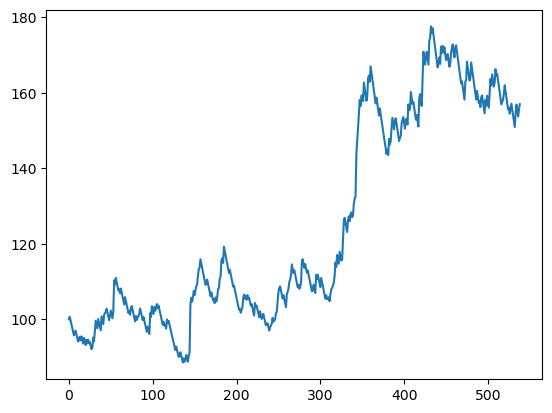

In [41]:
fig, ax = plt.subplots()
ax.plot(joined_fd['pot'])
ax.ticklabel_format(useOffset=False, style='plain')
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## Single Prediction

In [42]:
odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)
odds_fd = odds_fd.loc[:,~odds_fd.columns.str.contains('Unnamed')]
odds_fd.dropna(subset='home_team', inplace=True)
odds_fd['date'] = pd.to_datetime(odds_fd['date']).dt.date
odds_fd['home_team'] = odds_fd['home_team'].replace(' ', '_', regex=True).str.lower()
odds_fd['away_team'] = odds_fd['away_team'].replace(' ', '_', regex=True).str.lower()
odds_fd = odds_fd[['div', 'date', 'home_team', 'away_team', 'FTR', 'B365H', 'B365D', 'B365A']]

conditions  = [odds_fd['FTR']=='H', odds_fd['FTR']=='D', odds_fd['FTR']=='A']
choices     = [1, 0.5, 0]
odds_fd['FTR'] = np.select(conditions, choices)
odds_fd.rename(columns={'FTR': 'result',
                        'B365H': 'team_odds',
                        'B365A': 'opponent_odds',
                        'B365D': 'draw_odds'}, inplace=True)
odds_fd.dropna(subset='team_odds', inplace=True)
odds_fd.reset_index(inplace=True, drop=True)
dfs_preds_h_a = dfs_preds_cut.rename(columns={'loss': '0', 'draw': '1', 'win': '2'})

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/3153921656.py:1: DtypeWarning: Columns (3,11,118,145) have mixed types. Specify dtype option on import or set low_memory=False.
  odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)
/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/3153921656.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)


In [43]:
def transform_to_home_and_away(df):
    df['date'] = pd.to_datetime(df['date'])
    df_home = df[df['home'] == 1]
    df_away = df[df['home'] == 0]
    if 'result' in df_away.columns:
        df_away.drop('result', axis=1, inplace=True)

    df_home.rename(columns={'team': 'home_team', 'opponent': 'away_team', 'elo_team': 'elo_home', 'elo_opponent': 'elo_away',
                            '0': 'A', '1': 'D', '2': 'H'}, inplace=True)
    df_away.rename(columns={'team': 'away_team', 'opponent': 'home_team', 'elo_team': 'elo_away', 'elo_opponent': 'elo_home',
                            '0': 'H', '1': 'D', '2': 'A'}, inplace=True)

    df_combined = pd.concat([df_home, df_away])
    df_combined = df_combined.groupby(['date', 'home_team', 'away_team', 'elo_home', 'elo_away']).mean()
    df_combined.reset_index(inplace=True, drop=False)
    if 'result' in df_combined.columns:
        df_combined.drop(['result'], axis=1, inplace=True)
    df_combined['elo_diff'] = df_combined['elo_home'] - df_combined['elo_away']

    if 'team_goals_scored' not in df_home.columns:
        df_ftr = df_home.drop(['A', 'D', 'H', 'elo_diff', 'elo_home', 'elo_away', 'home'], axis=1)
        df_ftr['date'] = pd.to_datetime(df_ftr['date'])
    else:
        df_ftr = df_home.drop(['loss', 'draw', 'win', 'rest_days', 'team_goals_scored', 'opponent_goals_scored', 'elo_home', 'elo_away', 'home'], axis=1)
        df_ftr['date'] = pd.to_datetime(df_ftr['date'])

    df_combined = df_combined.merge(df_ftr, on=['date', 'home_team', 'away_team'], how='outer'
                                    )

    return df_combined

In [44]:
dfs_preds_h_a = transform_to_home_and_away(dfs_preds_h_a)
dfs_preds_h_a = dfs_preds_h_a.loc[:, ~dfs_preds_h_a.columns.str.contains('_x')]
dfs_preds_h_a = dfs_preds_h_a.loc[:, ~dfs_preds_h_a.columns.str.contains('_y')]

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/1402887065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_away.drop('result', axis=1, inplace=True)
/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/1402887065.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_home.rename(columns={'team': 'home_team', 'opponent': 'away_team', 'elo_team': 'elo_home', 'elo_opponent': 'elo_away',
/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/1402887065.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

In [45]:
dfs_preds_h_a['prediction'] = dfs_preds_h_a[['A', 'D', 'H']].idxmax(axis=1)
dfs_preds_h_a['prediction'] = dfs_preds_h_a['prediction'].replace({'H': 1, 'D': 0.5, 'A': 0})
dfs_preds_h_a['correct'] = np.where((dfs_preds_h_a['result'] == dfs_preds_h_a['prediction']), 1, 0)

In [46]:
dfs_preds_h_a['correct'].mean()

0.5378095396376932

In [47]:
dfs_preds_h_a['date'] = pd.to_datetime(dfs_preds_h_a['date']).dt.date

In [102]:
joined_h_a = pd.merge(dfs_preds_h_a, odds_fd,
                     left_on=['home_team', 'away_team', 'date', 'result'],
                     right_on=['home_team', 'away_team', 'date', 'result'],
                     how='inner')
joined_h_a = joined_h_a[joined_h_a['date']>=start_date]
joined_h_a.dropna(subset='team_odds', inplace=True)

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_71284/687170514.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_h_a = joined_h_a[joined_h_a['date']>=start_date]


In [103]:
def get_pred_odds(row):
    if row['prediction'] == 1:
        return row['team_odds']
    elif row['prediction'] == 0:
        return row['opponent_odds']
    else:
        return row['draw_odds']
    
joined_h_a['odds_bet'] = joined_h_a.apply(lambda x: get_pred_odds(x), axis=1)
joined_h_a['pot'] = 100
joined_h_a.reset_index(inplace=True, drop=True)

In [104]:
joined_h_a['correct'].mean()

0.5442622950819672

In [105]:
pot = [100]
win = []
bet_pct = 0.01

for index, row in joined_h_a.iterrows():
    if row['correct'] == 1:
        round_winnings = row['odds_bet'] * bet_pct * pot[index] - bet_pct * pot[index]
#         round_winnings = row['odds_bet'] - 1
    else:
        round_winnings = - bet_pct * pot[index]
#         round_winnings = - 1
    win.append(round_winnings)
    pot.append(round_winnings + pot[index])
    
joined_h_a['pot'] = pot[:-1]
joined_h_a['win'] = win

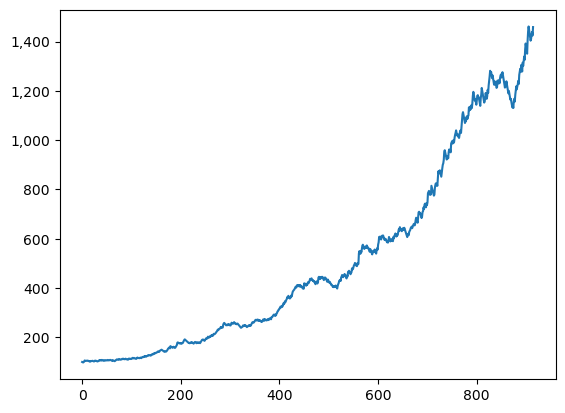

In [106]:
fig, ax = plt.subplots()
ax.plot(joined_h_a['pot'])
ax.ticklabel_format(useOffset=False, style='plain')
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [107]:
joined_h_a['prediction'].value_counts()

1.0    546
0.0    270
0.5     99
Name: prediction, dtype: int64

## Selective Betting

In [108]:
joined_h_a.head()

,date,home_team,away_team,elo_home,elo_away,elo_diff,home,A,D,H,result,prediction,correct,div,team_odds,draw_odds,opponent_odds,odds_bet,pot,win
0,2020-10-31,ascoli,pordenone,1396.911180,1480.802330,-83.891150,0.5,0.173005,0.195564,0.631431,0.0,1.0,0,I2,3.10,3.20,2.30,3.10,100.000000,-1.000000
1,2020-10-31,cittadella,monza,1499.161515,1511.655879,-12.494364,0.5,0.304188,0.208596,0.487216,0.0,1.0,0,I2,2.55,3.20,2.75,2.55,99.000000,-0.990000
2,2020-10-31,venezia,empoli,1507.037557,1547.525033,-40.487476,0.5,0.255305,0.196064,0.548630,1.0,1.0,1,I2,2.40,3.20,3.00,2.40,98.010000,1.372140
3,2020-11-14,virtus_entella,venezia,1452.872240,1517.800313,-64.928073,0.5,0.609325,0.272603,0.118072,0.0,0.0,1,I2,2.60,3.10,2.80,2.80,99.382140,1.788879
4,2020-11-20,frosinone,cosenza,1497.978474,1474.581916,23.396558,0.5,0.453478,0.269772,0.276750,0.0,0.0,1,I2,1.57,3.75,6.00,6.00,101.171019,5.058551


In [109]:
joined_h_a['correct'].mean()

0.5442622950819672

In [110]:
def convert_odds_to_prob(df, columns):
    for column in odds_columns:
        df[column] = 1 / df[column]
    return df

In [111]:
odds_columns = ['team_odds', 'draw_odds', 'opponent_odds']
joined_h_a = convert_odds_to_prob(joined_h_a, odds_columns)

In [112]:
# find biggest difference between predicted probabilities and odds probabilities
# place bet where the difference is greatest.

In [113]:
joined_h_a

,date,home_team,away_team,elo_home,elo_away,elo_diff,home,A,D,H,result,prediction,correct,div,team_odds,draw_odds,opponent_odds,odds_bet,pot,win
0,2020-10-31,ascoli,pordenone,1396.911180,1480.802330,-83.891150,0.5,0.173005,0.195564,0.631431,0.0,1.0,0,I2,0.322581,0.312500,0.434783,3.10,100.000000,-1.000000
1,2020-10-31,cittadella,monza,1499.161515,1511.655879,-12.494364,0.5,0.304188,0.208596,0.487216,0.0,1.0,0,I2,0.392157,0.312500,0.363636,2.55,99.000000,-0.990000
2,2020-10-31,venezia,empoli,1507.037557,1547.525033,-40.487476,0.5,0.255305,0.196064,0.548630,1.0,1.0,1,I2,0.416667,0.312500,0.333333,2.40,98.010000,1.372140
3,2020-11-14,virtus_entella,venezia,1452.872240,1517.800313,-64.928073,0.5,0.609325,0.272603,0.118072,0.0,0.0,1,I2,0.384615,0.322581,0.357143,2.80,99.382140,1.788879
4,2020-11-20,frosinone,cosenza,1497.978474,1474.581916,23.396558,0.5,0.453478,0.269772,0.276750,0.0,0.0,1,I2,0.636943,0.266667,0.166667,6.00,101.171019,5.058551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,2022-12-26,como,cittadella,1400.750483,1391.685611,9.064872,0.5,0.195433,0.362331,0.442235,1.0,1.0,1,I2,0.444444,0.322581,0.294118,2.25,1410.952454,17.636906
911,2022-12-26,frosinone,ternana,1507.559048,1443.302092,64.256957,0.5,0.251747,0.321933,0.426320,1.0,1.0,1,I2,0.571429,0.285714,0.200000,1.75,1428.589360,10.714420
912,2022-12-26,spal,pisa,1456.492604,1482.755881,-26.263277,0.5,0.264743,0.387523,0.347734,0.0,0.5,0,I2,0.380228,0.322581,0.370370,3.10,1439.303780,-14.393038
913,2022-12-26,sudtirol,modena,1509.993874,1497.904751,12.089123,0.5,0.401635,0.389778,0.208587,0.0,0.0,1,I2,0.444444,0.322581,0.294118,3.40,1424.910742,34.197858


In [368]:
# good lower bopund = 0.15

def in_threshold(row):
    lower_bound = 0.15
    upper_bound = 1
    if (row < upper_bound) & (row > lower_bound):
        return 1
    else:
        return 0

In [369]:
joined_h_a['difference_team'] = joined_h_a['H'] - joined_h_a['team_odds']
joined_h_a['difference_draw'] = joined_h_a['D'] - joined_h_a['draw_odds']
joined_h_a['difference_opp'] = joined_h_a['A'] - joined_h_a['opponent_odds']

joined_h_a['value_prediction'] = joined_h_a[['difference_team', 'difference_draw', 'difference_opp']].idxmax(axis=1)
joined_h_a['value_prediction'] = joined_h_a['value_prediction'].replace(
                    {'difference_team': 1, 'difference_draw': 0.5, 'difference_opp': 0})
joined_h_a['value_correct'] = np.where((joined_h_a['result'] == joined_h_a['value_prediction']), 1, 0)


joined_h_a['value_probability'] = joined_h_a[['difference_team', 'difference_draw', 'difference_opp']].max(axis=1)
joined_h_a['value_prediction_made'] = joined_h_a['value_probability'].apply(lambda x: in_threshold(x))

In [370]:
joined_h_a.head()

,date,home_team,away_team,elo_home,elo_away,elo_diff,home,A,D,H,...,win,difference_team,difference_draw,difference_opp,value_prediction,value_correct,value_probability,value_prediction_made,value_pot,value_win
0,2020-10-31,ascoli,pordenone,1396.911180,1480.802330,-83.891150,0.5,0.173005,0.195564,0.631431,...,-1.000000,0.308851,-0.116936,-0.261778,1.0,0,0.308851,1,100.0,-1.0
1,2020-10-31,cittadella,monza,1499.161515,1511.655879,-12.494364,0.5,0.304188,0.208596,0.487216,...,-0.990000,0.095059,-0.103904,-0.059449,1.0,0,0.095059,0,99.0,0.0
2,2020-10-31,venezia,empoli,1507.037557,1547.525033,-40.487476,0.5,0.255305,0.196064,0.548630,...,1.372140,0.131964,-0.116436,-0.078028,1.0,1,0.131964,0,99.0,0.0
3,2020-11-14,virtus_entella,venezia,1452.872240,1517.800313,-64.928073,0.5,0.609325,0.272603,0.118072,...,1.788879,-0.266543,-0.049977,0.252182,0.0,1,0.252182,1,99.0,1.8
4,2020-11-20,frosinone,cosenza,1497.978474,1474.581916,23.396558,0.5,0.453478,0.269772,0.276750,...,5.058551,-0.360193,0.003105,0.286812,0.0,1,0.286812,1,100.8,5.0


In [371]:
joined_h_a['value_correct'].mean()

0.4852459016393443

In [377]:
pot = [100]
win = []
bet_pct = 0.01

for index, row in joined_h_a.iterrows():
    if row['value_prediction_made'] == 1:
        if (row['value_correct'] == 1):
#             round_winnings = row['odds_bet'] * bet_pct * pot[index] - bet_pct * pot[index]
            round_winnings = row['odds_bet'] - 1
        else:
#             round_winnings = - bet_pct * pot[index]
            round_winnings = - 1
    else:
        round_winnings = 0
    win.append(round_winnings)
    pot.append(round_winnings + pot[index])
    
joined_h_a['value_pot'] = pot[:-1]
joined_h_a['value_win'] = win

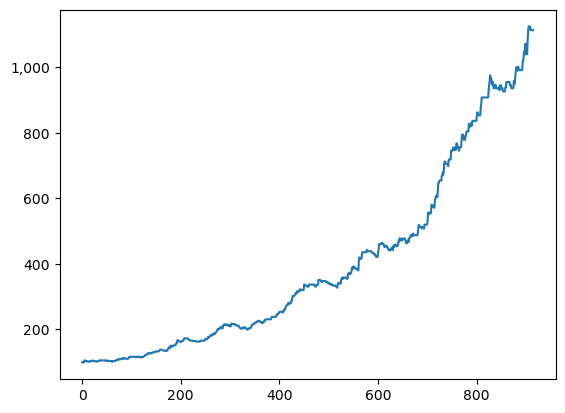

In [378]:
fig, ax = plt.subplots()
ax.plot(joined_h_a['value_pot'])
ax.ticklabel_format(useOffset=False, style='plain')
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [379]:
joined_h_a.tail()

,date,home_team,away_team,elo_home,elo_away,elo_diff,home,A,D,H,...,win,difference_team,difference_draw,difference_opp,value_prediction,value_correct,value_probability,value_prediction_made,value_pot,value_win
910,2022-12-26,como,cittadella,1400.750483,1391.685611,9.064872,0.5,0.195433,0.362331,0.442235,...,17.636906,-0.002209,0.039750,-0.098684,0.5,0,0.039750,0,1112.79188,0.0
911,2022-12-26,frosinone,ternana,1507.559048,1443.302092,64.256957,0.5,0.251747,0.321933,0.426320,...,10.714420,-0.145109,0.036219,0.051747,0.0,0,0.051747,0,1112.79188,0.0
912,2022-12-26,spal,pisa,1456.492604,1482.755881,-26.263277,0.5,0.264743,0.387523,0.347734,...,-14.393038,-0.032494,0.064942,-0.105628,0.5,0,0.064942,0,1112.79188,0.0
913,2022-12-26,sudtirol,modena,1509.993874,1497.904751,12.089123,0.5,0.401635,0.389778,0.208587,...,34.197858,-0.235858,0.067197,0.107518,0.0,1,0.107518,0,1112.79188,0.0
914,2022-12-26,venezia,parma,1430.085347,1451.930340,-21.844993,0.5,0.416718,0.379504,0.203778,...,-14.591086,-0.143445,0.067004,0.008555,0.5,1,0.067004,0,1112.79188,0.0


In [380]:
value_preds = joined_h_a[joined_h_a['value_prediction_made']==1]

(array([118.,  76.,  85.,  52.,  30.,  19.,   9.,   6.,   2.,   1.]),
 array([0.15038647, 0.19644331, 0.24250015, 0.288557  , 0.33461384,
        0.38067068, 0.42672753, 0.47278437, 0.51884121, 0.56489806,
        0.6109549 ]),
 <BarContainer object of 10 artists>)

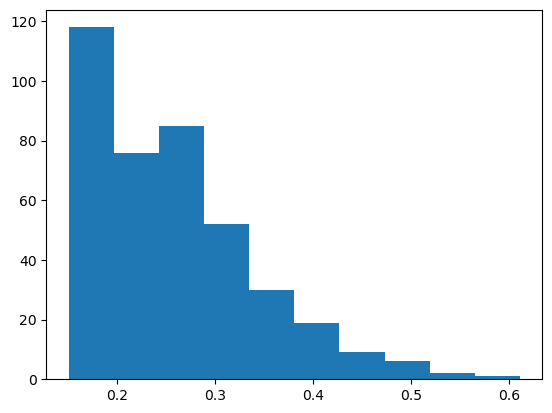

In [381]:
plt.hist(value_preds['value_probability'])